In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.ndimage import convolve
from scipy.spatial.distance import cdist

In [22]:
def define_roi(img, max_display_size=800, window_name="Select ROI"):
    """
    Displays a resizable window for ROI selection, then returns the cropped ROI from the original image.

    Parameters:
    - img: np.ndarray, the original image
    - max_display_size: int, maximum width or height to resize image for display (default: 800)
    - window_name: str, name of the selection window

    Returns:
    - cropped_img: np.ndarray, the cropped region of interest from the original image
    - (x, y, w, h): tuple of ROI coordinates in the original image
    """
    orig_h, orig_w = img.shape[:2]
    scale = min(max_display_size / orig_w, max_display_size / orig_h, 1.0)

    # Resize image for easier selection
    resized_w, resized_h = int(orig_w * scale), int(orig_h * scale)
    resized_image = cv2.resize(img, (resized_w, resized_h))

    # Let user select ROI
    roi = cv2.selectROI(window_name, resized_image, showCrosshair=True, fromCenter=False)
    cv2.destroyAllWindows()

    # Convert ROI coordinates back to original scale
    x, y, w, h = roi
    x = int(x / scale)
    y = int(y / scale)
    w = int(w / scale)
    h = int(h / scale)

    cropped_img = img[y:y+h, x:x+w]
    return cropped_img, (x, y, w, h)

def hist_equalize(img):
    '''
    Histogram equalization for grayscale or color images.
    '''
    if len(img.shape) == 2:
        equalized_img = cv2.equalizeHist(img)
    else:
        channels = cv2.split(img)
        equalized_channels = [cv2.equalizeHist(ch) for ch in channels]
        equalized_img = cv2.merge(equalized_channels)

    return equalized_img

def preprocess_img(img, canny_low_thresh=30, canny_up_thresh=100):
    '''
    Convert to gray, equalize histogram, denoise using Gaussian, and detect edges
    before finding the outlines.
    '''
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equalized = hist_equalize(gray)
    blur = cv2.bilateralFilter(equalized, d=5, sigmaColor=15, sigmaSpace=10)
    edges = cv2.Canny(blur, canny_low_thresh, canny_up_thresh)

    # New: Morphological closing to connect broken edge fragments
    
    kernel = np.ones((3, 3), np.uint8)
    closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    return closed_edges

In [23]:
def group_by_row(contours):
    grouped = defaultdict(list)  # maps y -> list of (x, y)

    for c in contours:
        for point in c:
            x, y = point[0]
            grouped[y].append((x, y))

    # Sort each row's points by x
    grouped_sorted = []
    for y in sorted(grouped.keys()):
        row = sorted(grouped[y], key=lambda pt: pt[0])
        grouped_sorted.append(row)

    return grouped_sorted

def filter_contours(contours, pts_fraction=0.1, alpha=0.5):
    filtered_contours = []
    grouped_contours = group_by_row(contours)

    if not grouped_contours:
        return []

    prev_left = grouped_contours[0][0][0]
    prev_right = grouped_contours[0][-1][0]

    for row in grouped_contours:
        y_value = row[0][1]

        row = sorted(row, key=lambda pt: pt[0])  # sort by x
        N = len(row)
        pts_thresh = max(1, int(N * pts_fraction))

        x_left = [pt[0] for pt in row[:pts_thresh]]
        x_right = [pt[0] for pt in row[-pts_thresh:]]

        x_min = np.mean(x_left)
        x_max = np.mean(x_right)

        # Exponential smoothing for continuity
        x_min = alpha * x_min + (1 - alpha) * prev_left
        x_max = alpha * x_max + (1 - alpha) * prev_right

        filtered_contours.append([(x_min, y_value), (x_max, y_value)])
        prev_left, prev_right = x_min, x_max

    return filtered_contours

def get_contours(edge, min_area = 100):
    contours, _ = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    larger_contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= min_area]
    return filter_contours(contours)

def get_contours_only(edge):
    contours, _ = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours

In [24]:
def plot_filtered_contour_outline(filtered_contours):
    # Extract left and right edges
    left_edge = [pt[0] for pt in filtered_contours]   # left side
    right_edge = [pt[1] for pt in filtered_contours]  # right side

    # Connect the outline: left edge (top→bottom), then right edge (bottom→top)
    outline = left_edge + right_edge[::-1]

    # Unzip x and y for plotting
    x_vals, y_vals = zip(*outline)

    return x_vals, y_vals


def remove_bg(image, filtered_contours, background_color=(0, 0, 0)):
    """
    Removes background by keeping pixels between (x_min, x_max) on each y-row.
    
    Args:
        image: The original RGB image (NumPy array).
        filtered_contours: List of [(x_min, y), (x_max, y)] pairs for each row.
        background_color: Color to assign to background pixels (default: black).
        
    Returns:
        Masked image with background removed.
    """
    masked_img = image.copy()

    for (x_min, y), (x_max, _) in filtered_contours:
        x_min = int(max(0, x_min))
        x_max = int(min(image.shape[1] - 1, x_max))
        y = int(y)
        
        # Set pixels to the left of x_min and right of x_max to background color
        if y >= 0 and y < image.shape[0]:
            masked_img[y, :x_min] = background_color
            masked_img[y, x_max+1:] = background_color

    return masked_img

def merge_layers(original_img, cropped_img, mask, ROI_coords, blur_ksize=(21, 21), sigma=0):
    x, y, w, h = ROI_coords

    # Step 1: Blur the original image
    blurred_img = cv2.GaussianBlur(original_img, blur_ksize, sigma)

    # Step 2: Prepare empty foreground and mask canvases
    foreground = np.zeros_like(original_img)
    mask_full = np.zeros(original_img.shape[:2], dtype=np.uint8)

    # Step 3: Ensure mask is single-channel binary
    if mask.ndim == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    _, mask_bin = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

    # Step 4: Paste cropped image and mask into correct location
    h_crop, w_crop = cropped_img.shape[:2]
    foreground[y:y+h_crop, x:x+w_crop] = cropped_img
    mask_full[y:y+h_crop, x:x+w_crop] = mask_bin

    # Step 5: Composite like Photoshop (use mask to select from foreground or background)
    combined = np.where(mask_full[..., None] == 255, foreground, blurred_img)

    return combined

In [25]:
def gather_votes(edge_binary, window_size, local_vote_thresh):
    '''
    For every neighborhood in the image, count how many edge pixels are inside.
    If the number of edge pixels in that neighborhood exceeds a threshold,
    then every edge pixel in that neighborhood gets a vote. As the window 
    slides across the image, each edge pixel can receive multiple votes
    for being part of multiple dense neighborhoods.
    '''
    kernel = np.ones((window_size, window_size), dtype=np.uint8)
    
    # Step 1: Count edge pixels in each window (same as original)
    vote_map = convolve(edge_binary, kernel, mode='constant', cval=0)
    smoothed_votes = cv2.GaussianBlur(vote_map.astype(np.float32), (11, 11), 0)
    
    # Step 2: Create a mask for "dense" windows
    mask = (smoothed_votes >= local_vote_thresh).astype(np.uint8)
    
    # Step 3: Spread a vote from each dense window to its region (same logic as incrementing in original)
    vote_bin = convolve(mask, kernel, mode='constant', cval=0)
    
    return vote_bin

def interpolate_contours(edge_binary):
    contours, _ = cv2.findContours(edge_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    canvas = np.zeros_like(edge_binary)

    for cnt in contours:
        if len(cnt) > 1:
            for i in range(len(cnt) - 1):
                pt1 = tuple(cnt[i][0])
                pt2 = tuple(cnt[i + 1][0])
                cv2.line(canvas, pt1, pt2, 255, thickness=1)

    return canvas

def remove_border_noise(img, border=15):
    img[:border, :] = 0          # Top
    img[-border:, :] = 0         # Bottom
    img[:, :border] = 0          # Left
    img[:, -border:] = 0         # Right
    return img

def remove_dense_noise(binary_edge_map, window_size=25, global_vote_thresh=100):
    edge_binary = (binary_edge_map > 0).astype(np.uint8)

    local_vote_thresh = int(0.5*window_size)

    votes = gather_votes(edge_binary, window_size, local_vote_thresh)

    filtered = binary_edge_map.copy()
    filtered[votes > global_vote_thresh] = 0

    connected_edges = interpolate_contours(filtered)
    result = remove_border_noise(connected_edges)

    return result, votes

In [29]:
# img = cv2.imread('../images/clay.png')
img = cv2.imread('../images/beach.jpg')
# img = cv2.imread('segment.jpg')
cropped_img, roi_points = define_roi(img)

In [30]:
img_edge = preprocess_img(cropped_img)
# edge_binary: binary edge map with values {0, 1}

global_vote_thresh=112
filtered, votes = remove_dense_noise(img_edge, window_size=25, global_vote_thresh=global_vote_thresh)

print(np.unique(votes))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

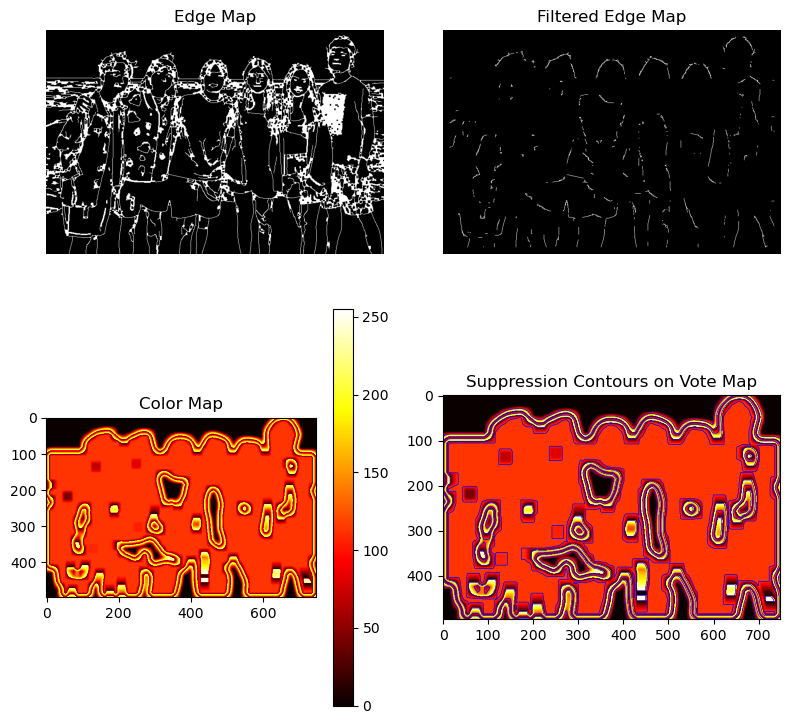

In [31]:
plt.figure(figsize=(8, 8))

plt.subplot(221); plt.imshow(img_edge, cmap='gray'); plt.title('Edge Map'); plt.axis('off')
plt.subplot(222); plt.imshow(filtered, cmap='gray'); plt.title('Filtered Edge Map'); plt.axis('off')
plt.subplot(223); plt.imshow(votes, cmap='hot'); plt.colorbar(); plt.title('Color Map')
plt.subplot(224); plt.imshow(votes, cmap='hot'); plt.contour(votes > global_vote_thresh, colors='blue', linewidths=0.5); plt.title('Suppression Contours on Vote Map')

plt.tight_layout()
plt.show()

In [ ]:
contours = get_contours(filtered)
contours_only = get_contours_only(filtered)

mask = np.zeros_like(cropped_img)  # grayscale image same size as input
# cv2.drawContours(mask, contours, -1, (70, 100, 255), thickness=1)

background_removed = remove_bg(cropped_img, contours)
final_output = merge_layers(img, cropped_img, background_removed, roi_points, (25, 25), 5)

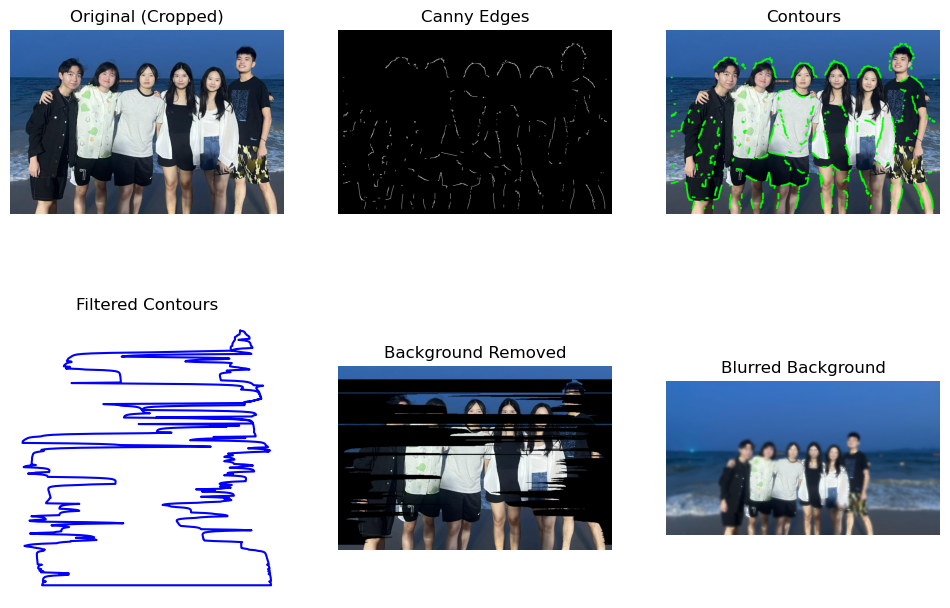

In [ ]:
# for subplot 3
contours_img = cropped_img.copy()
contours_img = cv2.cvtColor(contours_img, cv2.COLOR_BGR2RGB)
contours_img = cv2.drawContours(contours_img,  contours_only, -1, (0,255,0), 3)

# for subplot 4
x_vals, y_vals = plot_filtered_contour_outline(contours)

# Display All
plt.figure(figsize=(12, 8))

plt.subplot(231); plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)); plt.title('Original (Cropped)'); plt.axis('off')
plt.subplot(232); plt.imshow(filtered, cmap="gray"); plt.title('Canny Edges'); plt.axis('off')
plt.subplot(233); plt.imshow(contours_img); plt.title('Contours'); plt.axis('off')
plt.subplot(234); plt.plot(x_vals, y_vals, color='blue'); plt.gca().invert_yaxis(); plt.title('Filtered Contours'); plt.axis('off')
plt.subplot(235); plt.imshow(cv2.cvtColor(background_removed, cv2.COLOR_BGR2RGB)); plt.title('Background Removed'); plt.axis('off')
plt.subplot(236); plt.imshow(cv2.cvtColor(final_output, cv2.COLOR_BGR2RGB)); plt.title('Blurred Background'); plt.axis('off')

plt.show()

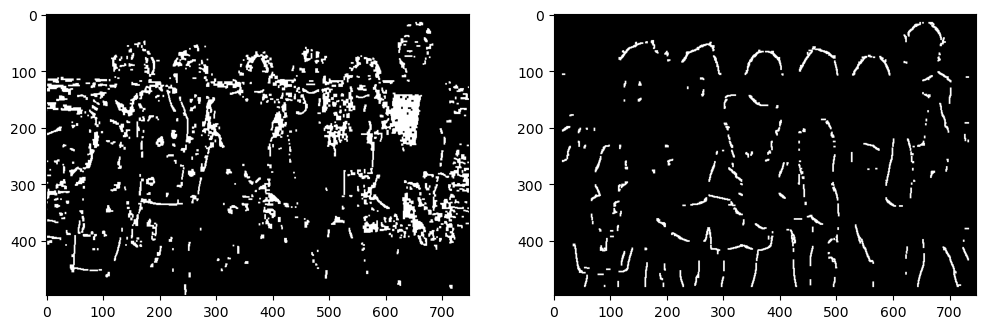

In [69]:
kernelSize = (3, 3)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
opening = cv2.morphologyEx(img_edge, cv2.MORPH_OPEN, kernel)
gradient = cv2.morphologyEx(filtered, cv2.MORPH_GRADIENT, kernel)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(opening, cmap='gray')

plt.subplot(122)
plt.imshow(gradient, cmap='gray')
plt.show()